In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import random
import itertools as it
import time
from IPython.display import display, Image, clear_output
from scipy import ndimage
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import cross_val_score
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

### Download tar files that contain the images

In [2]:
%%time
url = 'http://commondatastorage.googleapis.com/books1000/'

def download(filename):
    destination_file = "data/" + filename
    if not os.path.exists(destination_file):
        print("Dowloading ", filename, "into ", destination_file)
        urlretrieve(url + filename, destination_file)
    else:
        print("File already exists: ", filename)
    return destination_file

test_filename = download('notMNIST_small.tar.gz')
train_filename = download('notMNIST_large.tar.gz')
print("Untar Finished")

File already exists:  notMNIST_small.tar.gz
File already exists:  notMNIST_large.tar.gz
Untar Finished
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.8 ms


### Untar downloaded files

In [3]:
%%time

def untar(filename):
    folder = filename.split(".tar")[0]
    if os.path.isdir(folder):
        print("%s already extracted" %filename)
    else:
        print("Extracting %s, please wait" %filename)
#         tar = tarfile.open(filename)
#         sys.stdout.flush()
#         tar.extractall("data")
#         tar.close()
    extracted_folders = [
        os.path.join(folder, subfolder) for subfolder in sorted(os.listdir(folder))
        if os.path.isdir(os.path.join(folder, subfolder))]
    print(extracted_folders)
    return extracted_folders

test_folders = untar(test_filename)
train_folders = untar(train_filename)

../data/notMNIST_small.tar.gz already extracted
['../data/notMNIST_small/A', '../data/notMNIST_small/B', '../data/notMNIST_small/C', '../data/notMNIST_small/D', '../data/notMNIST_small/E', '../data/notMNIST_small/F', '../data/notMNIST_small/G', '../data/notMNIST_small/H', '../data/notMNIST_small/I', '../data/notMNIST_small/J']
../data/notMNIST_large.tar.gz already extracted
['../data/notMNIST_large/A', '../data/notMNIST_large/B', '../data/notMNIST_large/C', '../data/notMNIST_large/D', '../data/notMNIST_large/E', '../data/notMNIST_large/F', '../data/notMNIST_large/G', '../data/notMNIST_large/H', '../data/notMNIST_large/I', '../data/notMNIST_large/J']
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 649 ms


### Visualizing the data

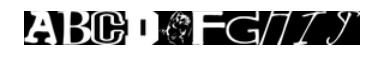

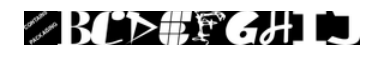

In [4]:
# display a three random image from each letter in the train folder
def print_images(folders):
    images = []
    for folder in train_folders:
        images_path = os.listdir(folder)
        for i in range(1):
            image_path = os.path.join(folder,
                                      random.choice(images_path))
            images.append(ndimage.imread(image_path))
#             images.append(plt.imread(image_path))
    plt.imshow(np.hstack(images), cmap = 'gray')
    plt.axis('off')
    plt.show()

print_images(test_folders)
print_images(train_folders)

In [5]:
%%time
image_size = 28

def load_letter(folder, min_num_images):
    image_paths = os.listdir(folder)
    dataset = np.ndarray(shape = (len(image_paths), image_size,
                                image_size), dtype=np.float32)
    for image_index, image in enumerate(os.listdir(folder)):
        image_path = os.path.join(folder, image)
        try:
            image_data = ndimage.imread(image_path).astype(float)
#             image_data = plt.imread(image_path).astype(float)
            image_data = (image_data - np.max(image_data) / 2) / np.max(image_data)

            if image_data.shape != (image_size, image_size):
                raise Exception("Unexpected image shape")
            dataset[image_index, :, :] = image_data
        except Exception as e:
            print("Error reading", image_path," : ", e, ",- Skipping")
    
    num_images = image_index
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))
    print('\tFull dataset tensor: ', dataset.shape)
    print('\tMean:', np.mean(dataset))
    print('\tStandard deviation: ', np.std(dataset))
    return dataset
    
def pickle_images(data_folders, min_num_images_per_class):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + ".pickle"
        dataset_names.append(set_filename)
        if not os.path.isfile(set_filename):
            print("Getting Images from ", folder)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, "wb") as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print("Unable to save data to ", set_filename, " : ", e)
        else:
            print("Pickle file already exists", set_filename)
    return dataset_names

print("Saving Pickles of Test Data")
test_datasets = pickle_images(test_folders, 1800)
print("\nSaving Pickles of Training Data")
train_datasets = pickle_images(train_folders, 45000)

Saving Pickles of Test Data
Pickle file already exists ../data/notMNIST_small/A.pickle
Pickle file already exists ../data/notMNIST_small/B.pickle
Pickle file already exists ../data/notMNIST_small/C.pickle
Pickle file already exists ../data/notMNIST_small/D.pickle
Pickle file already exists ../data/notMNIST_small/E.pickle
Pickle file already exists ../data/notMNIST_small/F.pickle
Pickle file already exists ../data/notMNIST_small/G.pickle
Pickle file already exists ../data/notMNIST_small/H.pickle
Pickle file already exists ../data/notMNIST_small/I.pickle
Pickle file already exists ../data/notMNIST_small/J.pickle

Saving Pickles of Training Data
Pickle file already exists ../data/notMNIST_large/A.pickle
Pickle file already exists ../data/notMNIST_large/B.pickle
Pickle file already exists ../data/notMNIST_large/C.pickle
Pickle file already exists ../data/notMNIST_large/D.pickle
Pickle file already exists ../data/notMNIST_large/E.pickle
Pickle file already exists ../data/notMNIST_large/F.pi

### Display Dataset
Let's verify that the data still looks good. Displaying a sample of the letters in the pickle files

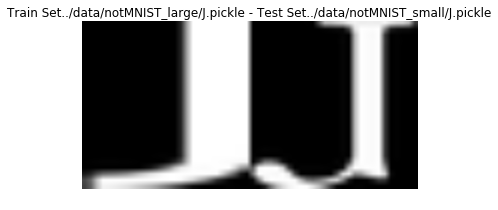

In [6]:
for pickle_file_train, pickle_file_test in zip(train_datasets, test_datasets):
    # encoding needs to be added beacuse pickle file was creted in python2
    letter_set_train = pickle.load(open(pickle_file_train, 'rb'), encoding='latin1')
    letter_set_test = pickle.load(open(pickle_file_test, 'rb'), encoding='latin1')
    np.random.shuffle(letter_set_train)
    np.random.shuffle(letter_set_test)
    for i in range(3):
        clear_output(wait="True")
        plt.imshow(np.hstack((letter_set_train[i], letter_set_test[i])), cmap = 'gray')
        plt.title("Train Set" + pickle_file_train + " - Test Set" + pickle_file_test)
        plt.axis('off')
        plt.show()
        time.sleep(0.5)

### Data Balanced
We excpect the data to be balanced across classes

In [7]:
for pickle_file_train, pickle_file_test in zip(train_datasets, test_datasets):
    # encoding needs to be added beacuse pickle file was creted in python2
    letter_set_train = pickle.load(open(pickle_file_train, 'rb'), encoding='latin1')
    print(pickle_file_train, ": ", len(letter_set_train))
for pickle_file_train, pickle_file_test in zip(train_datasets, test_datasets):
    # encoding needs to be added beacuse pickle file was creted in python2
    letter_set_test = pickle.load(open(pickle_file_test, 'rb'), encoding='latin1')
    print(pickle_file_test, ": ", len(letter_set_test))

../data/notMNIST_large/A.pickle :  52911
../data/notMNIST_large/B.pickle :  52911
../data/notMNIST_large/C.pickle :  52911
../data/notMNIST_large/D.pickle :  52911
../data/notMNIST_large/E.pickle :  52911
../data/notMNIST_large/F.pickle :  52911
../data/notMNIST_large/G.pickle :  52911
../data/notMNIST_large/H.pickle :  52911
../data/notMNIST_large/I.pickle :  52911
../data/notMNIST_large/J.pickle :  52910
../data/notMNIST_small/A.pickle :  1872
../data/notMNIST_small/B.pickle :  1872
../data/notMNIST_small/C.pickle :  1872
../data/notMNIST_small/D.pickle :  1872
../data/notMNIST_small/E.pickle :  1872
../data/notMNIST_small/F.pickle :  1872
../data/notMNIST_small/G.pickle :  1871
../data/notMNIST_small/H.pickle :  1871
../data/notMNIST_small/I.pickle :  1871
../data/notMNIST_small/J.pickle :  1871


### Make Dataset and Labels
Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [8]:
def make_labels_and_dataset(num_obs, img_size):
    dataset = np.ndarray((num_obs, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(num_obs, dtype=np.int32)
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_labels_and_dataset(valid_size, image_size)
    train_dataset, train_labels = make_labels_and_dataset(train_size, image_size)
    valid_size_per_class = valid_size // num_classes
    train_size_per_class = train_size // num_classes
    
    start_valid, start_train = 0, 0
    end_valid, end_train = valid_size_per_class, train_size_per_class
    end_total = valid_size_per_class + train_size_per_class
    for label, pickle_file in enumerate(pickle_files):
        print("Mergin Images from: ", pickle_file)
        letter_set = pickle.load(open(pickle_file, 'rb'), encoding='latin1')
        #shuffle letters
        np.random.shuffle(letter_set)
        valid_letter = letter_set[:valid_size_per_class, :, :]
        valid_dataset[start_valid:end_valid, :, :] = valid_letter
        valid_labels[start_valid:end_valid] = label
        start_valid += valid_size_per_class
        end_valid += valid_size_per_class
        
        train_letter = letter_set[valid_size_per_class:end_total, :, :]
        train_dataset[start_train:end_train, :, :] = train_letter
        train_labels[start_train:end_train] = label
        start_train += train_size_per_class
        end_train += train_size_per_class
    return valid_labels, valid_dataset, train_labels, train_dataset

train_size = 200000
valid_size = 10000
test_size = 10000

valid_labels, valid_dataset, train_labels, train_dataset = merge_datasets(train_datasets, train_size, valid_size)
_, _, test_labels, test_dataset = merge_datasets(test_datasets, test_size)   

Mergin Images from:  ../data/notMNIST_large/A.pickle
Mergin Images from:  ../data/notMNIST_large/B.pickle
Mergin Images from:  ../data/notMNIST_large/C.pickle
Mergin Images from:  ../data/notMNIST_large/D.pickle
Mergin Images from:  ../data/notMNIST_large/E.pickle
Mergin Images from:  ../data/notMNIST_large/F.pickle
Mergin Images from:  ../data/notMNIST_large/G.pickle
Mergin Images from:  ../data/notMNIST_large/H.pickle
Mergin Images from:  ../data/notMNIST_large/I.pickle
Mergin Images from:  ../data/notMNIST_large/J.pickle
Mergin Images from:  ../data/notMNIST_small/A.pickle
Mergin Images from:  ../data/notMNIST_small/B.pickle
Mergin Images from:  ../data/notMNIST_small/C.pickle
Mergin Images from:  ../data/notMNIST_small/D.pickle
Mergin Images from:  ../data/notMNIST_small/E.pickle
Mergin Images from:  ../data/notMNIST_small/F.pickle
Mergin Images from:  ../data/notMNIST_small/G.pickle
Mergin Images from:  ../data/notMNIST_small/H.pickle
Mergin Images from:  ../data/notMNIST_small/I.

In [9]:
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape) 

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


# Shuffle Data
Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.
Convince yourself that the data is still good after shuffling!

In [84]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

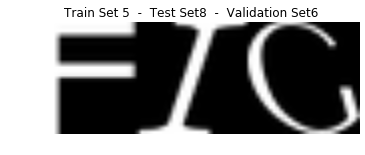

In [85]:
for i in np.random.randint(0, 1000, 3):
    clear_output(wait="Ture")
    plt.imshow(np.hstack((train_dataset[i, :, :], test_dataset[i, :, :], valid_dataset[i, :, :])), cmap = 'gray')
    plt.title("Train Set " + str(train_labels[i]) + 
              "  -  Test Set" + str(test_labels[i]) + 
              "  -  Validation Set" + str(valid_labels[i]))
    plt.axis('off')
    plt.show()
    time.sleep(1)

### Save Data for later in a pickle file

In [86]:
pickle_file = 'data/notMNIST_python3.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [34]:
pickle_file = 'data/notMNIST.pickle'
statinfo = os.stat(pickle_file)
print("Compresses pickle size: ", statinfo.st_size // 1048576, "MB")

Compresses pickle size:  658 MB


## Overlapping Examples
By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.

In [2]:
pickle_file = 'data/notMNIST_python3.pickle'

dic_file = pickle.load(open(pickle_file, 'rb'))
train_dataset = dic_file["train_dataset"]
train_labels = dic_file["train_labels"]
valid_dataset = dic_file["valid_dataset"]
valid_labels = dic_file["valid_labels"]
test_dataset = dic_file["test_dataset"]
test_labels = dic_file["test_labels"]

print("Examples in train dataset:", len(train_labels) / float(1000), "thousand")
print("Examples in valid dataset:", len(valid_labels) / float(1000), "thousand")
print("Examples in test dataset:", len(test_labels) / float(1000), "thousand")

Examples in train dataset: 200.0 thousand
Examples in valid dataset: 10.0 thousand
Examples in test dataset: 10.0 thousand


### Clean Datasets
We will check for repetitions within each datasets first. And remove the duplicates.

In [3]:
def are_equal(img1, img2):
    row = img1.shape[0] / 2
    if np.array_equal(img1[row, :], img2[row, :]):
        return np.array_equal(img1, img2)
    else:
        return False

def find_duplicates(labels1, dataset1, labels2=None, dataset2=None):
    classes = np.unique(labels1)
    duplicate_index = []
    try:
        if not labels2:
            for _class in classes:
                num_duplicates = 0
                index = np.where(labels1 == _class)[0]
                combinations = list(it.combinations(range(len(index)), 2))
                print("Comparisons to make for this class:", len(combinations) / float(1000000), "million")
                for i,j in combinations:
                    img1 = dataset1[i]
                    img2 = dataset1[j]
                    if are_equal(img1, img2) == True:
                        duplicate_index.append((i ,j))
                        num_duplicates += 1
                print("The number of matches found in class %d is %d\n" %(_class, num_duplicates))
            print("Total of matches: %d from a sample size: %d \n\n" %(len(duplicate_index), len(labels1)))
    
    except:
        for _class in classes:
            num_duplicates = 0
            index1 = np.where(labels1 == _class)[0]
            index2 = np.where(labels2 == _class)[0]
            print("Comparisons to make for this class:", len(index1) * len(index1) / float(1000000) / 2 , "million\n")
            for i in index1:
                for j in index2:
                    if j >= i:
                        img1 = dataset1[i]
                        img2 = dataset2[j]
                        if are_equal(img1, img2) == True:
                            duplicate_index.append((i ,j))
                            num_duplicates += 1
            print("The number of matches found in class %d is %d" %(_class, num_duplicates))
        print("Total of matches: %d from a sample size: %d \n\n" %(len(duplicate_index), len(labels1)))
    return duplicate_index
         
duplicate_index_valid = find_duplicates(valid_labels, valid_dataset)
# duplicate_index_test = find_duplicates(test_labels, test_dataset)
# duplicate_index_train = find_duplicates(train_labels, train_dataset)

Comparisons to make for this class: 0.4995 million


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


The number of matches found in class 0 is 78

Comparisons to make for this class: 0.4995 million
The number of matches found in class 1 is 78

Comparisons to make for this class: 0.4995 million
The number of matches found in class 2 is 78

Comparisons to make for this class: 0.4995 million
The number of matches found in class 3 is 78

Comparisons to make for this class: 0.4995 million
The number of matches found in class 4 is 78

Comparisons to make for this class: 0.4995 million
The number of matches found in class 5 is 78

Comparisons to make for this class: 0.4995 million
The number of matches found in class 6 is 78

Comparisons to make for this class: 0.4995 million
The number of matches found in class 7 is 78

Comparisons to make for this class: 0.4995 million
The number of matches found in class 8 is 78

Comparisons to make for this class: 0.4995 million
The number of matches found in class 9 is 78

Total of matches: 780 from a sample size: 10000 




(485, 617)


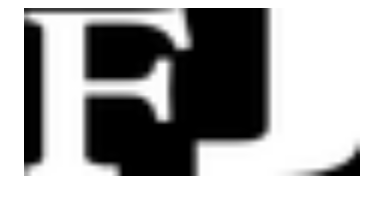

In [87]:
# view duplicated images
def print_images(img1, img2):
    plt.imshow(np.hstack((img1, img2)), cmap = "gray")
    plt.axis("off")
    plt.show()
    
index = random.choice(duplicate_index_test)
print(index)
print_images(test_dataset[index[0]], test_dataset[index[1]])
# matches seem to correspond to black images!!

### Remove Full Black Images

In [88]:
def remove_solid_color_images(dataset):
    rem_index = []
    for i in range(dataset.shape[0]):
        if len(np.unique(dataset[i])) == 1:
            rem_index.append(i)
    return rem_index
    
rem_index_valid = remove_solid_color_images(valid_dataset)
valid_labels = np.delete(valid_labels, rem_index_valid, 0)
valid_dataset = np.delete(valid_dataset, rem_index_valid, 0)

rem_index_test = remove_solid_color_images(test_dataset)
test_labels = np.delete(test_labels, rem_index_test, 0)
test_dataset = np.delete(test_dataset, rem_index_test, 0)

rem_index_train = remove_solid_color_images(train_dataset)
train_labels = np.delete(train_labels, rem_index_train, 0)
train_dataset = np.delete(train_dataset, rem_index_train, 0)

### Rerun duplication

In [55]:
duplicate_index_valid = find_duplicates(valid_labels, valid_dataset)
# duplicate_index_test = find_duplicates(test_labels, test_dataset)
# duplicate_index_train = find_duplicates(train_labels, train_dataset)

Comparisons to make for this class: 0.4995 million


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


The number of matches found in class 0 is 3

Comparisons to make for this class: 0.497503 million
The number of matches found in class 1 is 3

Comparisons to make for this class: 0.4995 million
The number of matches found in class 2 is 3

Comparisons to make for this class: 0.4995 million
The number of matches found in class 3 is 3

Comparisons to make for this class: 0.4995 million
The number of matches found in class 4 is 3

Comparisons to make for this class: 0.4995 million
The number of matches found in class 5 is 3

Comparisons to make for this class: 0.4995 million
The number of matches found in class 6 is 3

Comparisons to make for this class: 0.4995 million
The number of matches found in class 7 is 3

Comparisons to make for this class: 0.385881 million
The number of matches found in class 8 is 1

Comparisons to make for this class: 0.498501 million
The number of matches found in class 9 is 3

Total of matches: 28 from a sample size: 9876 


Comparisons to make for this class: 

## Save Cleaned Data

In [89]:
pickle_file = 'data/notMNIST_clean_python3.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

## Start from cleaned datasets

In [4]:
pickle_file = 'data/notMNIST_clean_python3.pickle'

dic_file = pickle.load(open(pickle_file, 'rb'))
train_dataset = dic_file["train_dataset"]
train_labels = dic_file["train_labels"]
valid_dataset = dic_file["valid_dataset"]
valid_labels = dic_file["valid_labels"]
test_dataset = dic_file["test_dataset"]
test_labels = dic_file["test_labels"]

print("Examples in train dataset:", len(train_labels) / float(1000), "thousand")
print("Examples in valid dataset:", len(valid_labels) / float(1000), "thousand")
print("Examples in test dataset:", len(test_labels) / float(1000), "thousand")

FileNotFoundError: [Errno 2] No such file or directory: 'data/notMNIST_clean_python3.pickle'

### Measuring overlap between sets

In [ ]:
print("Duplication Between VALID and TEST")
duplicate_index1 = find_duplicates(valid_labels, valid_dataset, test_labels, test_dataset)

# print "Duplication Between VALID and TRAIN"
# duplicate_index2 = find_duplicates(valid_labels, valid_dataset, train_labels, train_dataset)

# print "Duplication Between TRAIN and TEST"
# duplicate_index3 = find_duplicates(train_labels, train_dataset, test_labels, test_dataset)

Duplication Between VALID and TEST
Comparisons to make for this class: 0.5 million



/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


The number of matches found in class 0 is 7
Comparisons to make for this class: 0.5 million

The number of matches found in class 1 is 3
Comparisons to make for this class: 0.5 million



(5103, 5733)


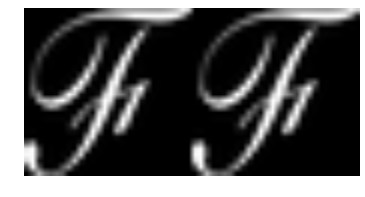

In [71]:
index = random.choice(duplicate_index1)
print(index)
print_images(valid_dataset[index[0]], test_dataset[index[1]])

# index = random.choice(duplicate_index2)
# print index
# print_images(valid_dataset[index[0]], train_dataset[index[1]])

# index = random.choice(duplicate_index3)
# print index
# print_images(train_dataset[index[0]], test_dataset[index[1]])

## LogisticRegression model
Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.


Train a simple model on this data using 50, 100, 1000 and 5000 training samples. 

Hint: you can use the LogisticRegression model from sklearn.linear_model.
Optional question: train an off-the-shelf model on all the data!


In [91]:
pickle_file = 'data/notMNIST_clean_python3.pickle'

dic_file = pickle.load(open(pickle_file, 'rb'))
train_dataset = dic_file["train_dataset"]
train_labels = dic_file["train_labels"]
valid_dataset = dic_file["valid_dataset"]
valid_labels = dic_file["valid_labels"]
test_dataset = dic_file["test_dataset"]
test_labels = dic_file["test_labels"]

print("Examples in train dataset:", len(train_labels) / float(1000), "thousand")
print("Examples in valid dataset:", len(valid_labels) / float(1000), "thousand")
print("Examples in test dataset:", len(test_labels) / float(1000), "thousand")

Examples in train dataset: 197.901 thousand
Examples in valid dataset: 9.876 thousand
Examples in test dataset: 9.857 thousand


In [103]:
def train_and_validate(num_examples):
    # flatten datasets
    flat_train = [x.flatten() for x in train_dataset[:num_examples]]
    flat_valid = [x.flatten() for x in valid_dataset[:num_examples]]
#     print(train_labels[:num_examples]) # Check if labels are really shuffled
    model = LogisticRegressionCV().fit(flat_train, train_labels[:num_examples])
    score = cross_val_score(model, flat_valid, valid_labels[:num_examples]).mean()
    return score

In [104]:
training_sizes = [50, 100, 1000, 5000]
print("Cross Validation Score\n")
for size in training_sizes:
    %time score = train_and_validate(size)
    print("Samples:", size,"---> Score:", score)

Cross Validation Score



/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be

CPU times: user 4.02 s, sys: 4 ms, total: 4.03 s
Wall time: 4.02 s
Samples: 50 ---> Score: 0.489729225023
CPU times: user 5.18 s, sys: 0 ns, total: 5.18 s
Wall time: 5.17 s
Samples: 100 ---> Score: 0.556342999891
CPU times: user 1min 3s, sys: 80 ms, total: 1min 3s
Wall time: 1min 3s
Samples: 1000 ---> Score: 0.754909265888
CPU times: user 9min 18s, sys: 1.22 s, total: 9min 19s
Wall time: 9min 19s
Samples: 5000 ---> Score: 0.809603342121
